# PCA² Analysis: Double Principal Component Analysis

## Overview

This notebook implements a sophisticated **PCA²** (PCA-squared) technique for analyzing XMM-Newton X-ray source data. The methodology consists of two sequential PCA applications:

1. **First PCA**: Standard dimensionality reduction on the original features
2. **Second PCA**: Analysis of the reconstruction errors from the first PCA

## Methodology & Motivation

The **reconstruction error** from the first PCA contains the unique, non-reducible characteristics of each source that couldn't be captured by the main principal components. By applying PCA to these reconstruction errors, we can:

- **Identify outliers and anomalous sources** that don't fit the main patterns
- **Discover subtle but systematic variations** missed by standard PCA
- **Reveal hidden structure** in the data's residual information
- **Perform advanced anomaly detection** for astronomical source classification

This approach is particularly powerful for astronomical data where rare or unusual sources may exhibit unique spectral or temporal properties that distinguish them from the general population.

## 1. Import Required Libraries

- **pandas & numpy**: Data manipulation and numerical operations
- **matplotlib**: Visualization and plotting
- **sklearn.decomposition.PCA**: Principal Component Analysis implementation
- **sklearn.preprocessing.StandardScaler**: Feature standardization for PCA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## 2. Load Preprocessed Data

Loading the cleaned XMM-Newton catalog from the preprocessing pipeline. This dataset contains high-quality X-ray sources with complete measurements and outliers removed.

In [3]:
df = pd.read_csv('4xmm_slim_dr14_preprocessed.csv', index_col=0)
df.head()

,sc_ra,sc_dec,sc_ep_1_flux,sc_ep_2_flux,sc_ep_3_flux,sc_ep_4_flux,sc_ep_5_flux,sc_ep_8_flux,sc_ep_9_flux,sc_ep_8_fmin,...,sc_hr4,sc_extent,sc_ext_ml,sc_chi2prob,mjd_first,mjd_last,sc_fvar,n_detections,datetime_first,datetime_last
iauname,,,,,,,,,,,,,,,,,,,,,
4XMM J000000.2-552106,0.000981,-55.351745,2.339110e-16,7.477733e-16,7.503544e-16,3.047059e-16,4.004341e-15,6.556074e-15,2.705045e-15,6.556074e-15,...,0.556416,0.0,-0.523192,1.0,56086.742951,56087.588194,0.0,1,2012-06-08 17:49:51,2012-06-09 14:07:00
4XMM J000000.2+623123,0.001078,62.523116,4.822757e-17,8.126540e-18,1.471056e-15,3.210278e-15,8.737898e-16,6.721141e-15,3.433501e-15,6.721141e-15,...,-0.848036,0.0,-0.796511,1.0,54134.485278,54135.043600,0.0,1,2007-02-03 11:38:48,2007-02-04 01:02:47
4XMM J000000.3-250629,0.001297,-25.108317,1.653872e-16,1.422986e-15,5.314440e-16,8.581970e-16,7.553166e-16,6.078558e-15,4.116765e-15,6.078558e-15,...,-0.215945,0.0,-0.598660,1.0,51696.440880,51696.788090,0.0,1,2000-06-01 10:34:52,2000-06-01 18:54:51
4XMM J000000.3-601742,0.001366,-60.295115,6.988109e-16,1.330748e-15,1.541574e-15,1.073534e-15,4.071881e-16,5.074447e-15,5.366679e-15,5.074447e-15,...,-0.684380,0.0,-0.874466,1.0,58972.676377,58972.858889,0.0,1,2020-05-03 16:13:59,2020-05-03 20:36:48
4XMM J000000.5-552138,0.002201,-55.360745,8.864110e-16,1.695742e-15,1.293371e-15,2.222728e-15,1.120018e-14,1.819022e-14,5.588499e-15,1.819022e-14,...,0.301328,0.0,-0.312634,1.0,56086.742951,56087.588194,0.0,1,2012-06-08 17:49:51,2012-06-09 14:07:00


## 3. Feature Selection for PCA Analysis

We select the most relevant numerical features for PCA analysis:

### Selected Features:
- **Flux measurements** (`sc_ep_*_flux`): X-ray flux in different energy bands
- **Flux limits** (`sc_ep_8_fmin/fmax`): Detection limits 
- **Hardness ratios** (`sc_hr1-4`): Spectral hardness indicators
- **Source properties**: 
  - `sc_extent`: Source spatial extent
  - `sc_ext_ml`: Maximum likelihood for extent
  - `sc_chi2prob`: Variability test probability
  - `sc_fvar`: Fractional variability
  - `n_detections`: Number of detections

These features capture the essential X-ray spectral, spatial, and temporal characteristics of each source.

In [4]:
df.columns

Index(['sc_ra', 'sc_dec', 'sc_ep_1_flux', 'sc_ep_2_flux', 'sc_ep_3_flux',
       'sc_ep_4_flux', 'sc_ep_5_flux', 'sc_ep_8_flux', 'sc_ep_9_flux',
       'sc_ep_8_fmin', 'sc_ep_8_fmax', 'sc_hr1', 'sc_hr2', 'sc_hr3', 'sc_hr4',
       'sc_extent', 'sc_ext_ml', 'sc_chi2prob', 'mjd_first', 'mjd_last',
       'sc_fvar', 'n_detections', 'datetime_first', 'datetime_last'],
      dtype='object')

In [5]:
df = df[[
'sc_ep_1_flux', 'sc_ep_2_flux', 'sc_ep_3_flux',
       'sc_ep_4_flux', 'sc_ep_5_flux', 'sc_ep_8_flux', 'sc_ep_9_flux',
       'sc_ep_8_fmin', 'sc_ep_8_fmax', 'sc_hr1', 'sc_hr2', 'sc_hr3', 'sc_hr4',
       'sc_extent', 'sc_ext_ml', 'sc_chi2prob', 'sc_fvar', 'n_detections'
]]
df.head()

,sc_ep_1_flux,sc_ep_2_flux,sc_ep_3_flux,sc_ep_4_flux,sc_ep_5_flux,sc_ep_8_flux,sc_ep_9_flux,sc_ep_8_fmin,sc_ep_8_fmax,sc_hr1,sc_hr2,sc_hr3,sc_hr4,sc_extent,sc_ext_ml,sc_chi2prob,sc_fvar,n_detections
iauname,,,,,,,,,,,,,,,,,,
4XMM J000000.2-552106,2.339110e-16,7.477733e-16,7.503544e-16,3.047059e-16,4.004341e-15,6.556074e-15,2.705045e-15,6.556074e-15,6.556074e-15,0.357308,0.104073,-0.878259,0.556416,0.0,-0.523192,1.0,0.0,1
4XMM J000000.2+623123,4.822757e-17,8.126540e-18,1.471056e-15,3.210278e-15,8.737898e-16,6.721141e-15,3.433501e-15,6.721141e-15,6.721141e-15,-0.930889,0.987450,-0.158213,-0.848036,0.0,-0.796511,1.0,0.0,1
4XMM J000000.3-250629,1.653872e-16,1.422986e-15,5.314440e-16,8.581970e-16,7.553166e-16,6.078558e-15,4.116765e-15,6.078558e-15,6.078558e-15,0.800173,-0.310173,-0.235250,-0.215945,0.0,-0.598660,1.0,0.0,1
4XMM J000000.3-601742,6.988109e-16,1.330748e-15,1.541574e-15,1.073534e-15,4.071881e-16,5.074447e-15,5.366679e-15,5.074447e-15,5.074447e-15,0.415405,-0.001515,-0.487231,-0.684380,0.0,-0.874466,1.0,0.0,1
4XMM J000000.5-552138,8.864110e-16,1.695742e-15,1.293371e-15,2.222728e-15,1.120018e-14,1.819022e-14,5.588499e-15,1.819022e-14,1.819022e-14,0.262650,-0.106951,-0.258388,0.301328,0.0,-0.312634,1.0,0.0,1


## 4. First PCA Application

### Step 4.1: Data Standardization and Initial PCA

**Why standardization is crucial:**
- X-ray measurements span vastly different scales (fluxes vs. hardness ratios)
- PCA is sensitive to feature scales
- StandardScaler ensures all features contribute equally

**PCA Configuration:**
- `n_components=0.99`: Retain 99% of the total variance
- This captures the main patterns while reducing dimensionality

In [6]:
# scaling of the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)
# PCA
pca = PCA(n_components=0.99)  # retain 99% of variance
pca.fit(scaled_data)
pca.explained_variance_ratio_

array([0.38522435, 0.11463746, 0.08615143, 0.07140363, 0.06170775,
       0.05736352, 0.05216019, 0.0499119 , 0.04774672, 0.0255205 ,
       0.01636499, 0.01180382, 0.00934263, 0.00397837])

### Step 4.2: Transform Data and Analyze Components

Transform the standardized data into PCA space and examine the principal components to understand what patterns they capture.

In [7]:
df_pca = pca.transform(scaled_data)
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,-1.464753,-0.263372,-0.841069,1.423775,-0.262773,0.047670,0.517245,-0.070366,-0.493716,-0.156526,-0.192385,0.024771,0.178360,-0.153583
1,-1.388772,0.905830,0.440173,-2.029378,-2.106898,0.036908,0.782344,0.169587,-0.167463,-0.822543,-0.113427,0.165243,-0.419255,-0.086619
2,-1.385682,-0.383118,-0.533336,0.169054,1.124300,-0.129161,-0.770003,-0.141434,0.081908,-0.092331,-0.012017,0.068739,0.071118,0.021927
3,-1.298196,-0.468137,-0.437473,-0.552166,0.491774,-0.185837,-0.012940,-0.118501,-0.084665,-0.834730,0.092745,0.131577,0.003187,0.036771
4,-0.944800,0.166160,-0.604584,0.649567,-0.169627,-0.035946,-0.613476,-0.096981,0.038393,0.109730,-0.154309,0.070193,0.063578,-0.009590


### Step 4.3: Interpret Principal Components

The PCA components matrix shows how each original feature contributes to each principal component. This helps us understand what physical/astronomical properties each PC represents:

- **Positive/negative loadings** indicate correlated/anti-correlated relationships
- **Large absolute values** show which features dominate each component
- **Component interpretation** reveals underlying astrophysical patterns

In [8]:
# interpretation of the PCA components
pca.components_
pca_components = pd.DataFrame(pca.components_, columns=df.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])
pca_components

,sc_ep_1_flux,sc_ep_2_flux,sc_ep_3_flux,sc_ep_4_flux,sc_ep_5_flux,sc_ep_8_flux,sc_ep_9_flux,sc_ep_8_fmin,sc_ep_8_fmax,sc_hr1,sc_hr2,sc_hr3,sc_hr4,sc_extent,sc_ext_ml,sc_chi2prob,sc_fvar,n_detections
PC1,0.261461,0.286039,0.336191,0.331338,0.279362,0.356554,0.343365,0.353119,0.346508,0.017179,-0.008040,0.003253,-0.026255,0.094210,0.030552,-0.184870,0.115891,0.026454
PC2,-0.262997,-0.324129,-0.139747,0.172809,0.382980,0.212906,-0.160928,0.219051,0.188930,-0.124644,0.294297,0.336288,0.128576,-0.100951,-0.039468,0.330242,-0.318148,-0.144940
PC3,-0.230895,-0.248240,-0.124480,0.073210,0.091996,0.010329,-0.149970,-0.012867,0.067465,-0.004320,0.239857,0.236929,-0.151578,-0.110916,-0.058991,-0.475726,0.548897,0.385207
PC4,-0.111303,-0.072614,-0.125084,-0.142827,0.236917,0.094834,-0.120405,0.085448,0.120980,0.152775,-0.269969,-0.400788,0.725284,-0.033323,-0.075989,-0.065408,0.104820,0.199234
PC5,-0.280093,-0.054219,0.012672,0.105975,0.050384,0.029636,0.010178,0.029214,0.029959,0.874410,-0.207721,0.030635,-0.279359,0.019170,-0.000993,0.084279,-0.087216,0.012097
PC6,-0.120611,-0.055818,-0.021103,-0.000364,0.004602,-0.012594,-0.033350,-0.017025,0.007321,-0.002929,0.086267,0.026110,0.094155,0.528212,0.819478,0.027994,0.030930,0.104715
PC7,-0.065623,-0.019489,0.200812,0.043712,-0.087362,-0.027728,0.094648,-0.040357,0.006053,0.122912,0.703505,-0.549240,-0.034872,-0.094267,-0.027135,0.111002,-0.154681,0.274364
PC8,-0.087413,-0.027475,0.004116,0.002153,-0.022641,-0.020276,-0.000243,-0.021112,-0.007043,-0.022040,0.086426,0.038760,0.023782,0.812448,-0.560755,0.053047,0.024875,0.046788
PC9,0.138560,0.088232,-0.020218,-0.011503,-0.052869,-0.011280,0.035405,-0.049340,0.092640,-0.087968,-0.219737,0.250287,-0.050021,-0.043577,-0.026244,0.218672,-0.325802,0.824356
PC10,0.112853,0.210556,0.138019,-0.015321,-0.232489,-0.106330,0.163687,-0.104318,-0.106158,0.315797,0.326882,0.533948,0.552948,-0.076109,-0.021835,-0.005597,0.061568,-0.042675


### Step 4.4: Visualize Component Structure

The heatmap visualization reveals:
- **Feature clustering**: Which measurements tend to vary together
- **Component specialization**: Whether components focus on specific aspects (spectral, spatial, temporal)
- **Correlation patterns**: How different X-ray properties relate to each other

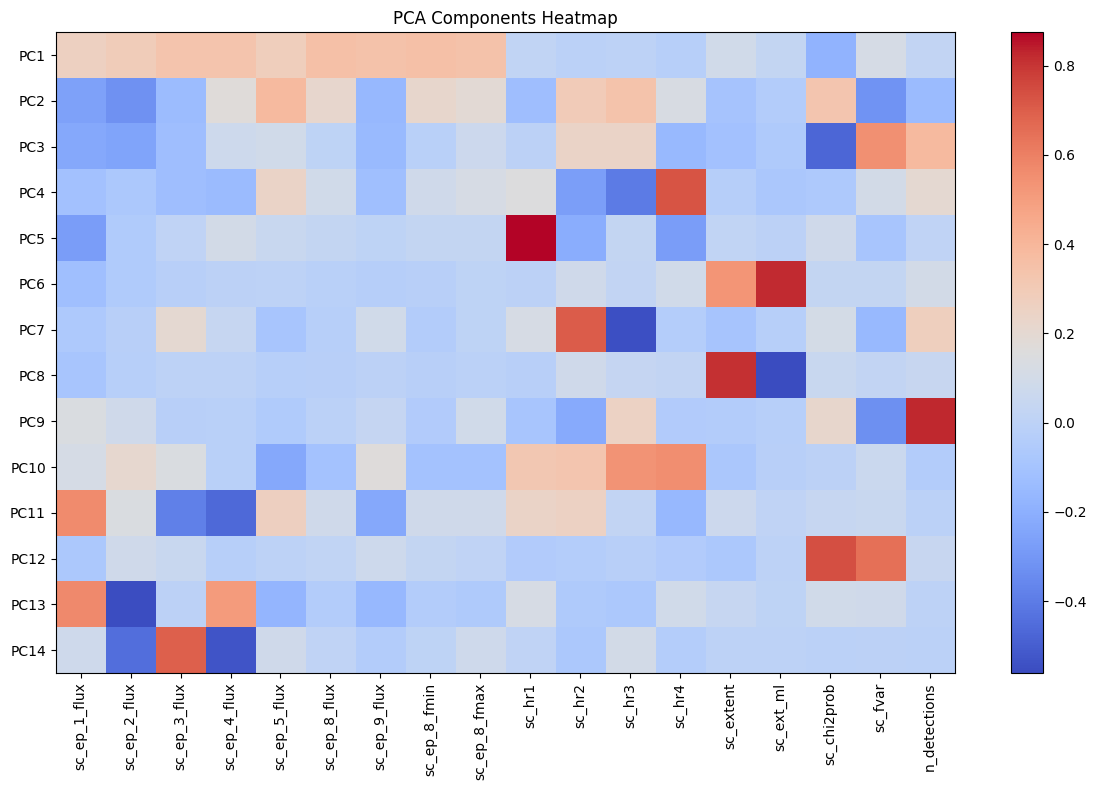

In [9]:
# visualization using a heatmap
plt.figure(figsize=(12, 8))
plt.imshow(pca_components, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(ticks=np.arange(len(pca_components.columns)), labels=pca_components.columns, rotation=90)
plt.yticks(ticks=np.arange(len(pca_components.index)), labels=pca_components.index)
plt.title('PCA Components Heatmap')
plt.tight_layout()
plt.show()

### Step 4.5: Visualize Data Distribution in PCA Space

The scatter plot of the first two principal components shows:
- **Data clustering**: Natural groupings of similar sources
- **Outliers**: Sources with extreme PC scores
- **Distribution shape**: Whether data follows expected patterns

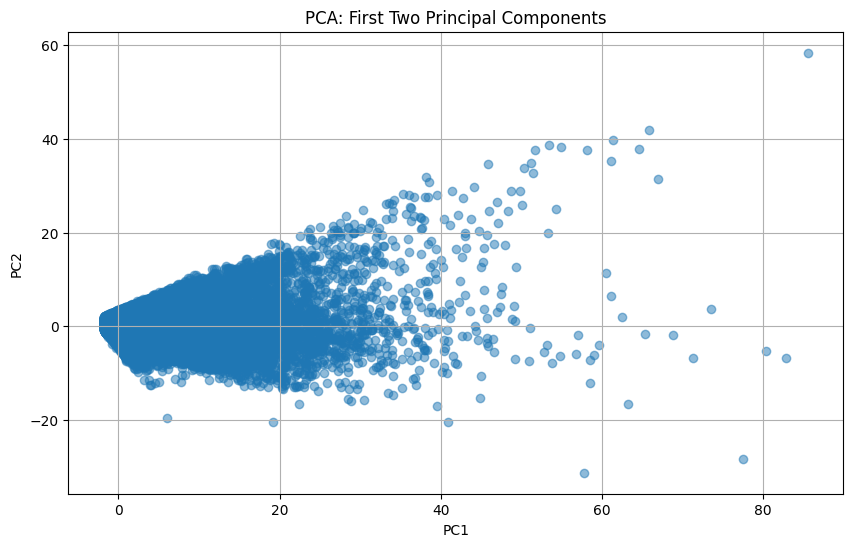

In [10]:
# scatter plot of the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.5)
plt.title('PCA: First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()

## 5. The Key Innovation: Analyzing Reconstruction Errors

### Step 5.1: Calculate Reconstruction Errors

**The Core Concept:**
When we reconstruct the original data from PCA components and subtract it from the scaled original data, we get **reconstruction errors**. These errors contain:

- **Unique characteristics** not captured by the main PCA patterns
- **Subtle variations** that distinguish individual sources
- **Noise and anomalies** that don't fit the general population
- **Potential new patterns** in the residual information

**Mathematical Process:**
1. `Reconstruction = PCA.inverse_transform(PCA_transformed_data)`
2. `Reconstruction_Error = Original_scaled_data - Reconstruction`

In [11]:
# create a dataframe with for each row the reconstruction errors for each PCA component
# subtract the original data from the PCA inverse transformed data
df_reconstruction = pd.DataFrame(pca.inverse_transform(df_pca.values), columns=df.columns, index=df.index)
df_reconstruction_errors = df_scaled - df_reconstruction

### Step 5.2: Standardize Reconstruction Errors

**Why standardize the errors?**
- Reconstruction errors may have different scales across features
- Standardization ensures fair treatment of all error components
- Prepares data for the second PCA application

In [12]:
df_reconstruction_errors_scaled = StandardScaler().fit_transform(df_reconstruction_errors)
df_reconstruction_errors_scaled = pd.DataFrame(df_reconstruction_errors_scaled, columns=df.columns, index=df.index)
df_reconstruction_errors_scaled.head()

,sc_ep_1_flux,sc_ep_2_flux,sc_ep_3_flux,sc_ep_4_flux,sc_ep_5_flux,sc_ep_8_flux,sc_ep_9_flux,sc_ep_8_fmin,sc_ep_8_fmax,sc_hr1,sc_hr2,sc_hr3,sc_hr4,sc_extent,sc_ext_ml,sc_chi2prob,sc_fvar,n_detections
iauname,,,,,,,,,,,,,,,,,,
4XMM J000000.2-552106,0.118331,0.045722,0.039842,0.121361,0.149701,-0.195698,-0.009806,-0.185966,0.061331,-0.157410,-0.053418,-0.049179,-0.006756,-0.009696,-0.016383,0.126895,0.136872,-0.077698
4XMM J000000.2+623123,-0.000954,0.168993,0.163664,0.215653,0.085261,-0.123704,-0.143220,-0.098188,0.031353,-0.211313,0.094514,0.019106,0.123709,0.014629,-0.140491,0.164361,0.161817,-0.034935
4XMM J000000.3-250629,-0.046963,-0.057663,-0.077275,-0.084442,-0.094658,0.050149,0.044208,-0.055112,0.069676,0.034002,-0.024797,-0.085867,-0.021283,-0.083212,0.026765,0.008362,0.014262,-0.072445
4XMM J000000.3-601742,0.310501,-0.020777,-0.002572,0.120056,0.339661,-0.300266,0.084673,-0.229204,0.005640,-0.135128,-0.188403,-0.017765,-0.126674,0.069805,0.089671,0.076137,0.094117,-0.035457
4XMM J000000.5-552138,0.109999,0.101054,0.115614,0.173772,0.182999,-0.128741,-0.065191,-0.081277,-0.029143,-0.142652,0.005243,0.055856,0.031819,0.077396,-0.051988,0.086690,0.087975,0.019138


## 6. Second PCA: The "Squared" Analysis

### Step 6.1: Apply PCA to Reconstruction Errors

**This is where PCA² gets its name!**

We now apply PCA to the reconstruction errors themselves. This second PCA reveals:
- **Hidden patterns** in what the first PCA couldn't capture
- **Systematic variations** in the residual information  
- **Outlier structure** and anomaly patterns
- **Secondary modes of variation** in the data

In [13]:
# apply PCA to the reconstruction errors
pca_reconstruction_errors = PCA(n_components=0.99)
pca_reconstruction_errors.fit(df_reconstruction_errors_scaled.values)
pca_reconstruction_errors.explained_variance_ratio_

array([0.53981575, 0.35041289, 0.07811727, 0.03165409])

### Step 6.2: Interpret Reconstruction Error Components

The PCA components of reconstruction errors reveal which original features contribute most to the **residual patterns** - the unique characteristics that distinguish sources from the main population trends.

In [14]:
# interpret the PCA components of the reconstruction errors
pca_reconstruction_errors.components_
# create a DataFrame for the PCA components of the reconstruction errors
pca_reconstruction_errors_components = pd.DataFrame(pca_reconstruction_errors.components_,
                                                   columns=df_reconstruction_errors_scaled.columns,
                                                   index=[f'PC{i+1}' for i in range(pca_reconstruction_errors.n_components_)])
pca_reconstruction_errors_components

,sc_ep_1_flux,sc_ep_2_flux,sc_ep_3_flux,sc_ep_4_flux,sc_ep_5_flux,sc_ep_8_flux,sc_ep_9_flux,sc_ep_8_fmin,sc_ep_8_fmax,sc_hr1,sc_hr2,sc_hr3,sc_hr4,sc_extent,sc_ext_ml,sc_chi2prob,sc_fvar,n_detections
PC1,0.274807,-0.260529,-0.202832,-0.225322,0.198438,0.087039,0.269669,0.125053,-0.191867,0.305847,-0.266780,0.104725,-0.296130,0.168408,0.298791,-0.304172,-0.294879,0.179120
PC2,0.019773,0.230273,0.305046,0.251243,0.190853,0.264325,-0.214843,0.275594,-0.318897,-0.005810,0.198722,0.375854,0.143734,0.330992,-0.142678,-0.088566,-0.113507,0.328966
PC3,0.432572,0.062519,0.093446,0.275460,0.523367,-0.141734,0.037728,-0.449397,-0.023020,-0.248056,-0.205219,0.020784,-0.111778,0.154131,0.053706,0.185121,0.217658,-0.039903
PC4,-0.033268,-0.030299,-0.042844,-0.056920,-0.065991,0.896031,0.021006,-0.386263,0.014479,0.087306,-0.016198,-0.056197,-0.008528,-0.002597,0.011499,0.076633,0.112594,-0.077578


### Step 6.3: Visualize Reconstruction Error Components

This heatmap shows how reconstruction errors are structured:
- **Different patterns** compared to the original PCA components
- **Feature relationships** in the residual space
- **Error dominance**: Which measurements contribute most to uniqueness

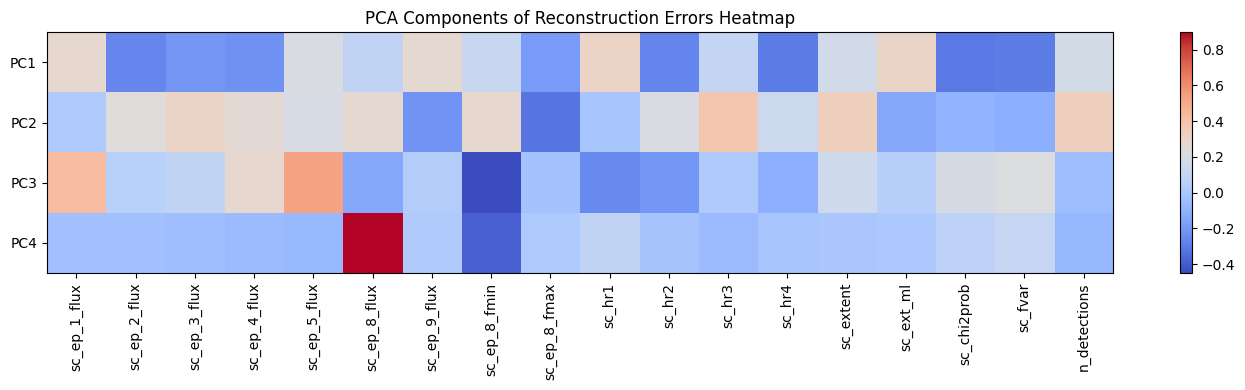

In [32]:
# visualize it using a heatmap
plt.figure(figsize=(14, 4))
plt.imshow(pca_reconstruction_errors_components, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(ticks=np.arange(len(pca_reconstruction_errors_components.columns)), labels=pca_reconstruction_errors_components.columns, rotation=90)
plt.yticks(ticks=np.arange(len(pca_reconstruction_errors_components.index)), labels=pca_reconstruction_errors_components.index)
plt.title('PCA Components of Reconstruction Errors Heatmap')
plt.tight_layout()
plt.show()

### Step 6.4: Transform Errors to PCA Space

Transform the standardized reconstruction errors into the new PCA space defined by the error components. This creates a new coordinate system where each axis represents a mode of **uniqueness** or **deviation** from the main population.

In [34]:
df_pca_reconstruction_errors = pca_reconstruction_errors.transform(df_reconstruction_errors_scaled.values)
df_pca_reconstruction_errors = pd.DataFrame(df_pca_reconstruction_errors,
                                            columns=[f'PC{i+1}' for i in range(df_pca_reconstruction_errors.shape[1])],
                                            index=df_reconstruction_errors_scaled.index)
df_pca_reconstruction_errors

,PC1,PC2,PC3,PC4
iauname,,,,
4XMM J000000.2-552106,-0.176261,-0.118709,0.382825,-0.105710
4XMM J000000.2+623123,-0.444800,0.145730,0.266347,-0.095709
4XMM J000000.3-250629,0.002643,-0.208721,-0.092815,0.102602
4XMM J000000.3-601742,0.124437,-0.147284,0.629782,-0.204128
4XMM J000000.5-552138,-0.155732,0.155273,0.336814,-0.121080
...,...,...,...,...
4XMM J235958.3+681605,-0.309781,0.404425,0.333536,-0.160204
4XMM J235958.4+443342,0.093631,-0.008275,-0.831178,0.345875
4XMM J235958.8-251113,0.359882,0.182718,0.488571,-0.221573


## 7. Key Findings: The Remarkable Structure

### Step 7.1: The Cross Pattern Discovery

The most striking result of this PCA² analysis is revealed in the scatter plot of reconstruction error principal components.

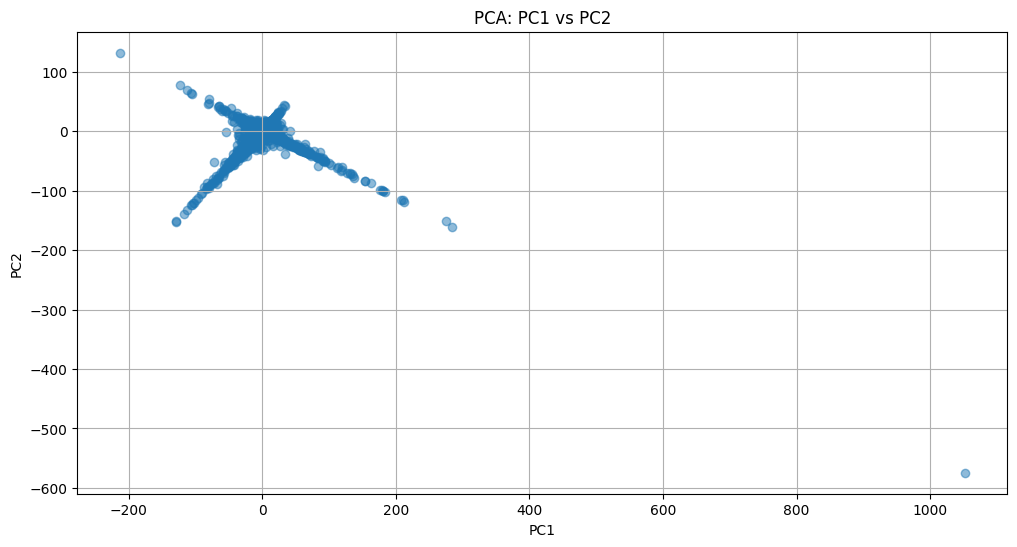

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(df_pca_reconstruction_errors['PC1'], df_pca_reconstruction_errors['PC2'], alpha=0.5)
plt.title('PCA: PC1 vs PC2') # almost 90% of the variance!
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()

### Step 7.2: Interpreting the Cross Structure

**What this pattern reveals:**

🎯 **Central Region (Cross Center)**: 
- Sources that are **well-reconstructed** by standard PCA
- "Typical" sources following main population trends
- Can be interpreted as the **noise region**

✨ **Four Arms/Clusters**: 
- Sources with **systematic deviations** from typical behavior
- Four distinct **modes of uniqueness**
- Potential **subpopulations** with different astrophysical properties

📊 **High Variance Concentration**: 
- Nearly **90% of uniqueness variance** captured in just 2 dimensions
- Indicates highly structured patterns in what makes sources unique

## 8. Comprehensive Pattern Analysis

### Step 8.1: Multi-dimensional Structure Exploration

To fully understand the structure revealed by PCA², we examine all pairwise combinations of the first four principal components. This reveals whether the cross pattern is unique to PC1-PC2 or part of a larger multidimensional structure.

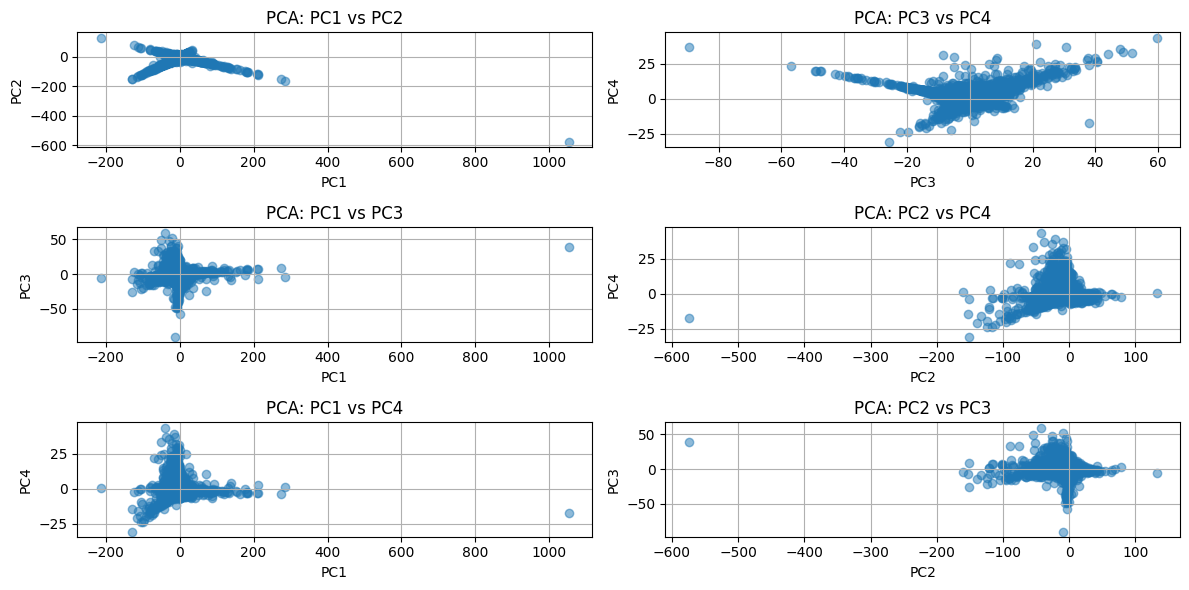

In [25]:
# create a plot with one figure for PC1 and PC2 and one for PC3 and PC4
plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 1)
plt.scatter(df_pca_reconstruction_errors['PC1'], df_pca_reconstruction_errors['PC2'], alpha=0.5)
plt.title('PCA: PC1 vs PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.subplot(3, 2, 2)
plt.scatter(df_pca_reconstruction_errors['PC3'], df_pca_reconstruction_errors['PC4'], alpha=0.5)
plt.title('PCA: PC3 vs PC4')
plt.xlabel('PC3')
plt.ylabel('PC4')
plt.grid()
# add plot for PC1 and PC3, and PC2 and PC4
plt.subplot(3, 2, 3)
plt.scatter(df_pca_reconstruction_errors['PC1'], df_pca_reconstruction_errors['PC3'], alpha=0.5)
plt.title('PCA: PC1 vs PC3')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.grid()
plt.subplot(3, 2, 4)
plt.scatter(df_pca_reconstruction_errors['PC2'], df_pca_reconstruction_errors['PC4'], alpha=0.5)
plt.title('PCA: PC2 vs PC4')
plt.xlabel('PC2')
plt.ylabel('PC4')
plt.grid()
# add a plot for PC1 and PC4, and PC2 and PC3
plt.subplot(3, 2, 5)
plt.scatter(df_pca_reconstruction_errors['PC1'], df_pca_reconstruction_errors['PC4'], alpha=0.5)
plt.title('PCA: PC1 vs PC4')
plt.xlabel('PC1')
plt.ylabel('PC4')
plt.grid()
plt.subplot(3, 2, 6)
plt.scatter(df_pca_reconstruction_errors['PC2'], df_pca_reconstruction_errors['PC3'], alpha=0.5)
plt.title('PCA: PC2 vs PC3')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.grid()
plt.tight_layout()
plt.show()

## 9. Summary and Implications

### What PCA² Has Revealed

🔬 **Methodological Success**: The PCA² technique successfully uncovered hidden structure in XMM-Newton X-ray source data that would be invisible to standard PCA alone.

🎯 **Key Discovery**: Sources exhibit four distinct **modes of uniqueness** arranged in a cross pattern, with ~90% of the "uniqueness variance" captured in just two dimensions.

### Astrophysical Implications

**Four Distinct Source Types**: The cross structure suggests four fundamental ways that X-ray sources can deviate from typical behavior:
- Different spectral hardness patterns
- Unique flux variability signatures  
- Distinct spatial/temporal characteristics
- Novel combinations of X-ray properties

**Anomaly Detection**: Sources far from the center are prime candidates for detailed astrophysical follow-up - they represent the most unusual objects in the catalog.

**Population Studies**: The clear clustering suggests natural subpopulations that could correspond to different source classes (AGN, stellar coronae, X-ray binaries, etc.).

### Next Steps

1. **Cluster Analysis**: Apply clustering algorithms to the reconstruction error PC space
2. **Astrophysical Characterization**: Investigate what makes each cluster unique
3. **Outlier Investigation**: Study the most extreme sources for new discoveries
4. **Cross-matching**: Compare clusters with known source classifications

This PCA² analysis demonstrates how advanced dimensionality reduction techniques can reveal hidden structure in complex astronomical datasets, opening new avenues for discovery and classification.